In [1]:
import networkx as nx
from ego_graph_dataset import select_active_graph
from tqdm import tqdm
import pandas as pd
import os
from utils import scores2coalition, PlotUtils
from torch_geometric.utils import to_networkx, from_networkx
import matplotlib.pyplot as plt
import utils
from gspan_mine.gspan_mining.config import parser
from gspan_mine.gspan_mining.main import main

/home/elouan/.local/lib/python3.8/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/elouan/.local/lib/python3.8/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN2at4_ops6narrow4callERKNS_6TensorElll
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/elouan/.local/lib/python3.8/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/elouan/.local/lib/python3.8/site-packages/torch_sparse/_diag_cpu.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
RULE = 23
DATASET = 'mutagenicity'
METRIC = 'entropy'
NODE_SELECTION = 'fixed_size'

In [3]:
# Build the graph.data file for a given rule
def build_graph_data(dataset='mutagenicity' ,rule=23, metric='entropy', node_selection='fixed_size'):
    graphs = select_active_graph(f'/home/elouan/epita/lre/gnn_explainability/src/activ_ego/mutag_{rule}labels_egos.txt', 2,0,[])
    skipped_index = []
    with open(f'results/{dataset}_{rule}_{metric}_{node_selection}.data', 'w+') as f:
        for i in tqdm(range(3490)):
            graph = to_networkx(graphs[i], to_undirected=True, node_attrs=['center', 'x'])
            df_node_score = pd.read_csv(os.path.join("./results/mutagenicity/gcn/gstarx",
                             f"result_{dataset}_{rule}_{i}.csv"))
            if df_node_score is None or len(df_node_score) == 0:
                skipped_index.append(i)
                continue
            node_score = df_node_score[metric].values
            coalition = scores2coalition(node_score, sparsity=0.5, fixed_size=True, size=3)
            # If the node that has the label 'center' to True in the graph is not in the coalition, add it
            for node in graph.nodes():
                if graph.nodes[node]['center'] and node not in coalition:
                    coalition.append(node)
            # Select the subgraph induce by the coalition
            subgraph = graph.subgraph(coalition)
            f.write(f't # {i}\n')
            for node in subgraph.nodes():
                f.write(f'v {int(node)} {graph.nodes[node]["x"]}\n')
            for edge in subgraph.edges():
                f.write(f'e {int(edge[0])} {int(edge[1])} 0\n')
    print(f"Skipped {len(skipped_index)} graphs")

In [4]:
build_graph_data(DATASET, RULE, METRIC, NODE_SELECTION)

Number of graphs: 4278


100%|██████████████████████████████████████| 3490/3490 [00:04<00:00, 847.64it/s]

Skipped 67 graphs


t # 0
v 0 0
v 1 0
e 0 1 0

Support: 3414


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


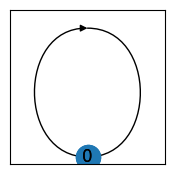


-----------------

t # 1
v 0 0
v 1 0
v 2 0
e 0 1 0
e 1 2 0

Support: 3173


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


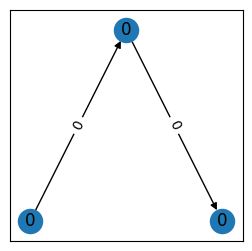


-----------------

t # 2
v 0 0
v 1 0
v 2 0
v 3 0
e 0 1 0
e 1 2 0
e 1 3 0

Support: 1141


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


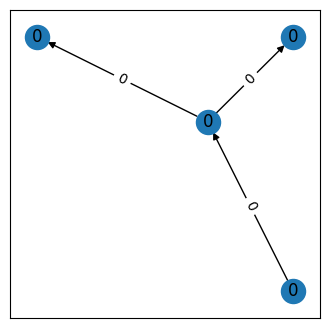


-----------------

Read:	0.04 s
Mine:	0.58 s
Total:	0.62 s


In [5]:
# Run gspan mining on the graph.data file
min_support = 1000
args_str = f'-s {min_support} -p True ./results/{DATASET}_{RULE}_{METRIC}_{NODE_SELECTION}.data'
FLAGS, _ = parser.parse_known_args(args=args_str.split())
gs = main(FLAGS)

In [7]:
# Build the graph.data file for a given rule
def build_graph_data_neighbors(dataset='mutagenicity' ,rule=23, metric='entropy', node_selection='fixed_size'):
    graphs = select_active_graph(f'/home/elouan/epita/lre/gnn_explainability/src/activ_ego/mutag_{rule}labels_egos.txt', 2,0,[])
    skipped_index = []
    with open(f'results/{dataset}_{rule}_{metric}_{node_selection}_with_neighbors.data', 'w+') as f:
        for i in tqdm(range(3490)):
            graph = to_networkx(graphs[i], to_undirected=True, node_attrs=['center', 'x'])
            df_node_score = pd.read_csv(os.path.join("./results/mutagenicity/gcn/gstarx",
                             f"result_{dataset}_{rule}_{i}.csv"))
            if df_node_score is None or len(df_node_score) == 0:
                skipped_index.append(i)
                continue
            node_score = df_node_score[metric].values
            coalition = scores2coalition(node_score, sparsity=0.5, fixed_size=True, size=3)
            # If the node that has the label 'center' to True in the graph is not in the coalition, add it
            for node in graph.nodes():
                if graph.nodes[node]['center'] and node not in coalition:
                    coalition.append(node)
            # Select the subgraph induce by the coalition
            # Add direct neighbors of the coalition to the coalition without adding nodes that are already in the coalition
            for node in coalition:
                for neighbor in graph.neighbors(node):
                    if neighbor not in coalition:
                        coalition.append(neighbor)
            subgraph = graph.subgraph(coalition)
            f.write(f't # {i}\n')
            for node in subgraph.nodes():
                f.write(f'v {int(node)} {graph.nodes[node]["x"]}\n')
            for edge in subgraph.edges():
                f.write(f'e {int(edge[0])} {int(edge[1])} 0\n')
    print(f"Skipped {len(skipped_index)} graphs")

In [8]:
build_graph_data_neighbors(DATASET, RULE, METRIC, NODE_SELECTION)

Number of graphs: 4278


100%|██████████████████████████████████████| 3490/3490 [00:04<00:00, 808.89it/s]

Skipped 67 graphs


In [9]:
# Run gspan mining on the graph.data file
min_support = 1000
args_str = f'-s {min_support} -p True ./results/{DATASET}_{RULE}_{METRIC}_{NODE_SELECTION}_with_neighbors.data'

t # 0
v 0 0
v 1 4
e 0 1 0

Support: 2074


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


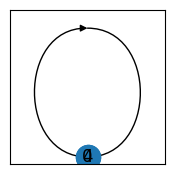


-----------------

t # 1
v 0 0
v 1 0
e 0 1 0

Support: 3414


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


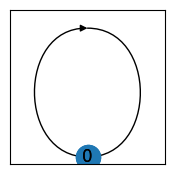


-----------------

t # 2
v 0 0
v 1 0
v 2 0
e 0 1 0
e 1 2 0

Support: 3410


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


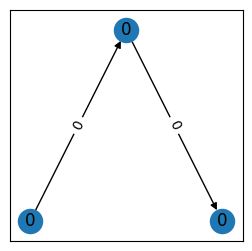


-----------------

t # 3
v 0 0
v 1 0
v 2 0
v 3 3
e 0 1 0
e 1 2 0
e 1 3 0

Support: 3379


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


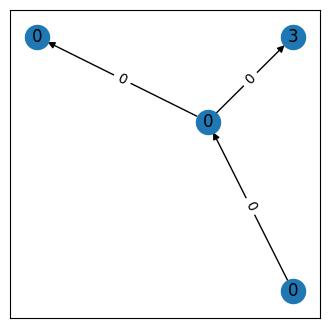


-----------------

t # 4
v 0 0
v 1 0
v 2 0
v 3 0
e 0 1 0
e 1 2 0
e 2 3 0

Support: 3226


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


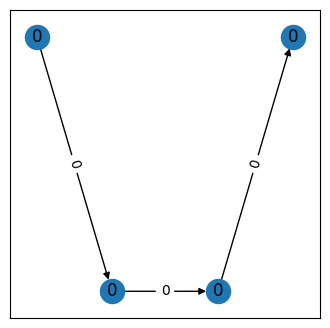


-----------------

t # 5
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 4 0

Support: 3217


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


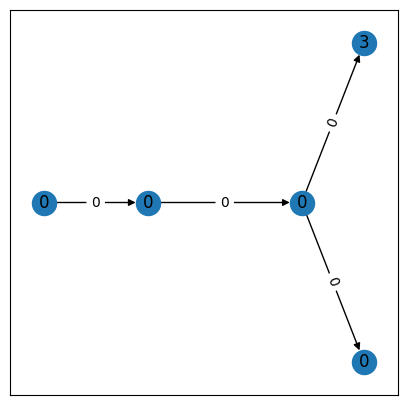


-----------------

t # 6
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 4
e 0 1 0
e 1 2 0
e 1 5 0
e 2 3 0
e 2 4 0

Support: 1669


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


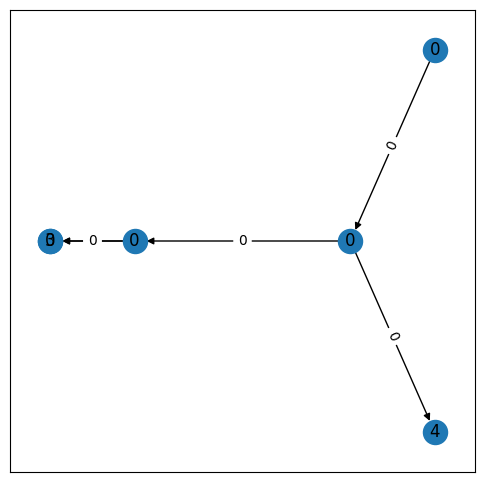


-----------------

t # 7
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
e 0 1 0
e 1 2 0
e 2 3 0
e 3 4 0

Support: 3104


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


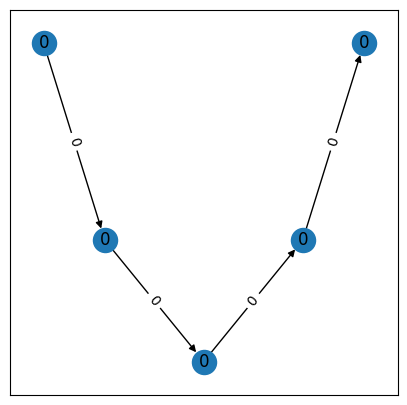


-----------------

t # 8
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
e 0 1 0
e 1 2 0
e 2 3 0
e 3 4 0
e 3 5 0

Support: 2459


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


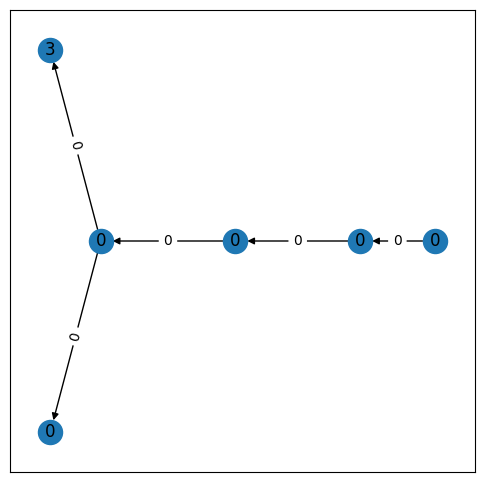


-----------------

t # 9
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
v 6 3
e 0 1 0
e 1 2 0
e 1 6 0
e 2 3 0
e 3 4 0
e 3 5 0

Support: 1678


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


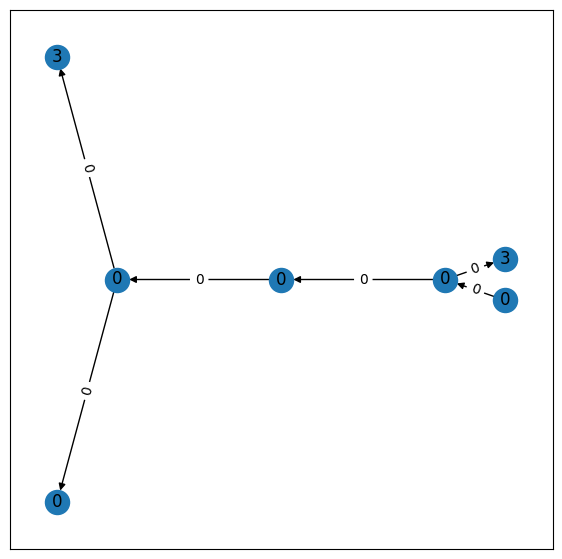


-----------------

t # 10
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
v 6 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0

Support: 1378


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


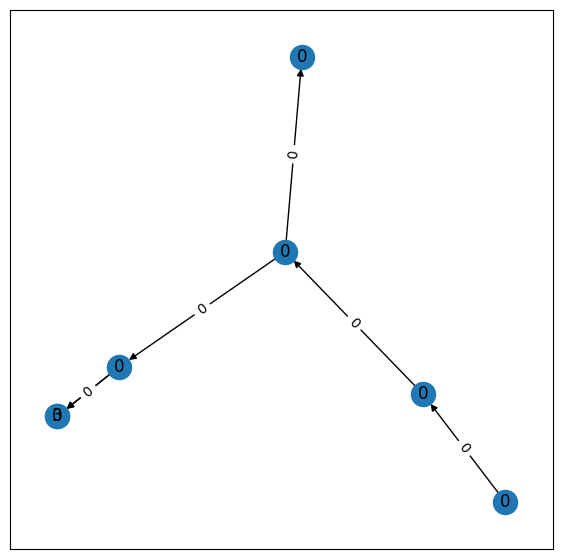


-----------------

t # 11
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
v 6 0
v 7 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0

Support: 1287


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


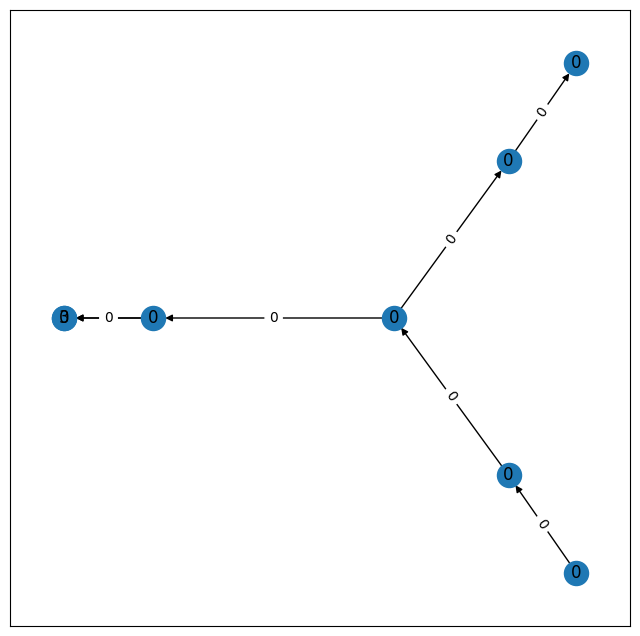


-----------------

t # 12
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
v 6 0
v 7 0
v 8 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0
e 6 8 0

Support: 1287


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


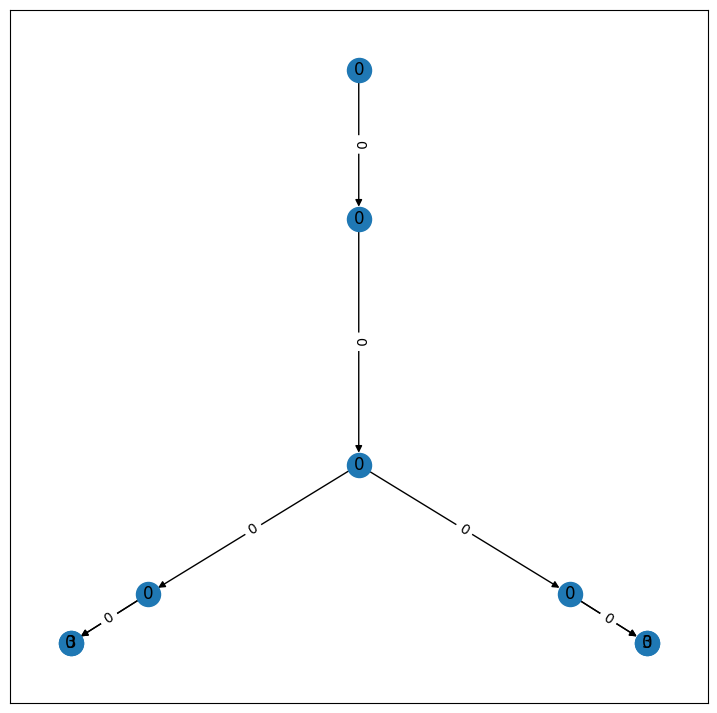


-----------------

t # 13
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
v 6 0
v 7 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0

Support: 1369


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


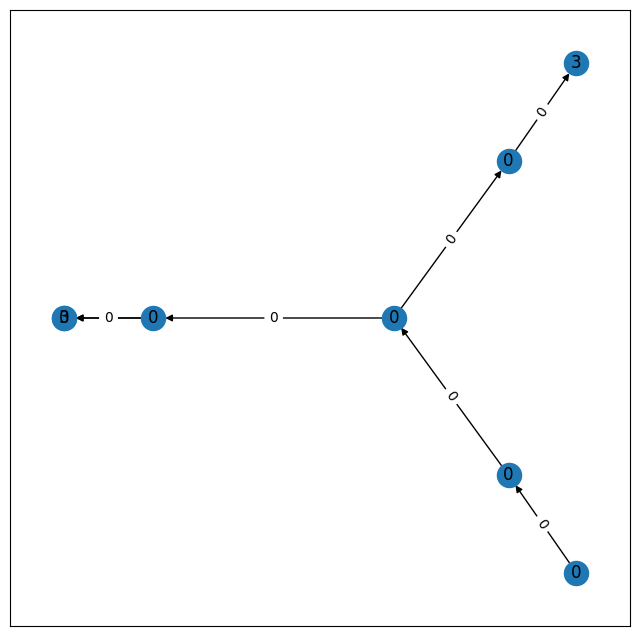


-----------------

t # 14
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
v 6 0
v 7 3
e 0 1 0
e 1 2 0
e 1 7 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0

Support: 1301


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


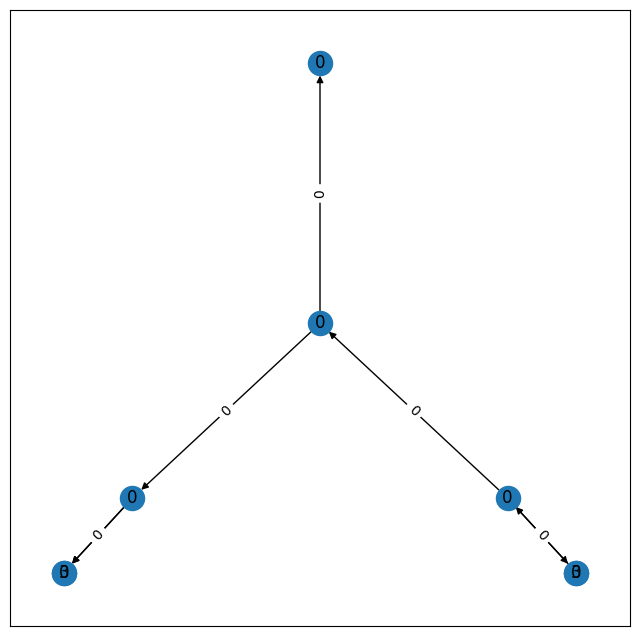


-----------------

t # 15
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 5 0
e 3 4 0

Support: 1380


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


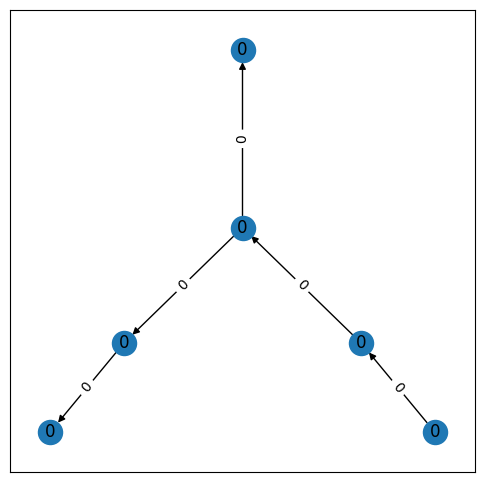


-----------------

t # 16
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 5 0
e 3 4 0
e 5 6 0

Support: 1287


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


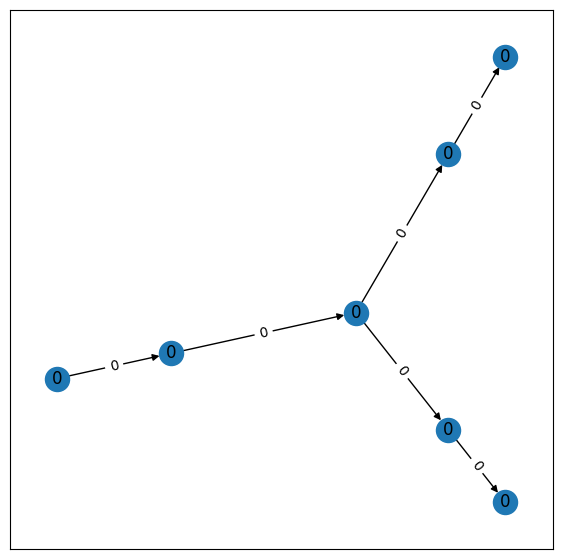


-----------------

t # 17
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 5 0
e 3 4 0
e 5 6 0

Support: 1370


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


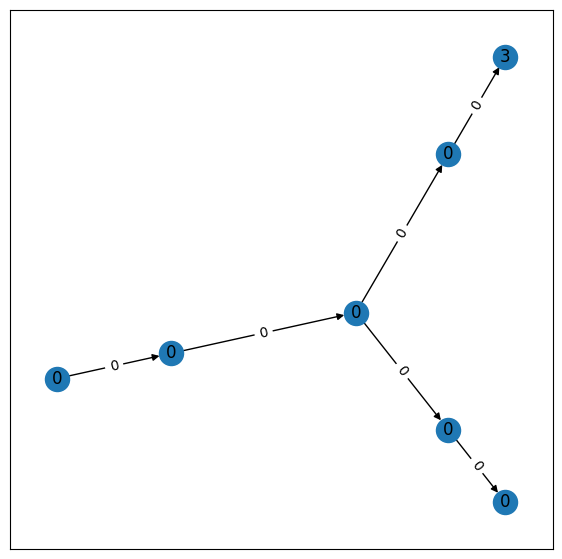


-----------------

t # 18
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
e 0 1 0
e 1 2 0
e 2 3 0
e 3 4 0
e 3 5 0

Support: 1656


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


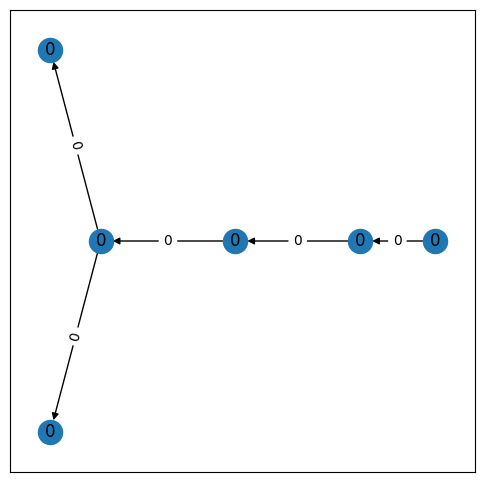


-----------------

t # 19
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0

Support: 1216


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


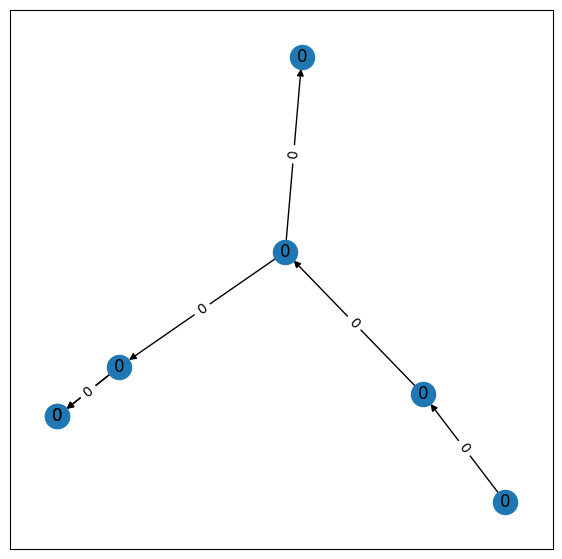


-----------------



/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


t # 20
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
v 7 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0

Support: 1206


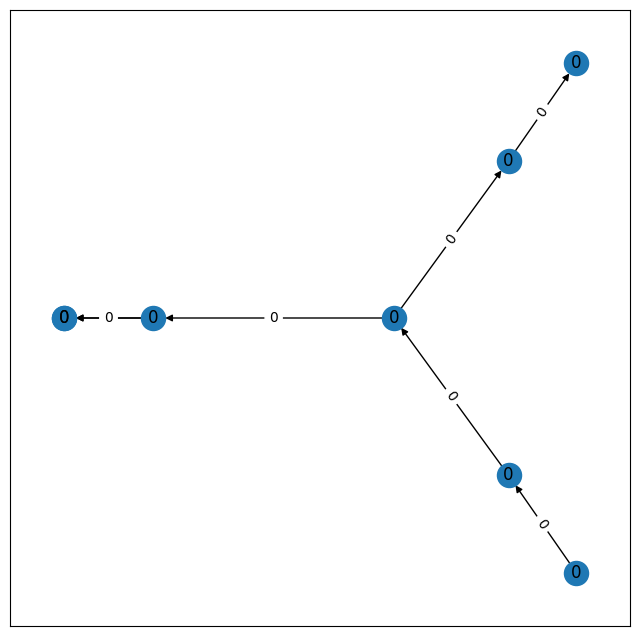


-----------------

t # 21
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
v 7 0
v 8 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0
e 6 8 0

Support: 1206


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


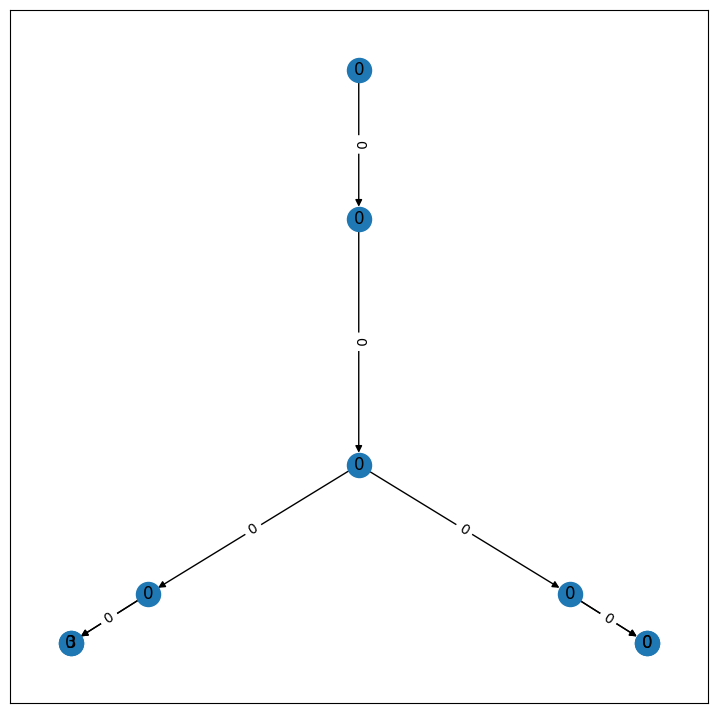


-----------------

t # 22
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
v 7 0
v 8 3
v 9 3
e 0 1 0
e 1 2 0
e 1 9 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0
e 6 8 0

Support: 1205


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


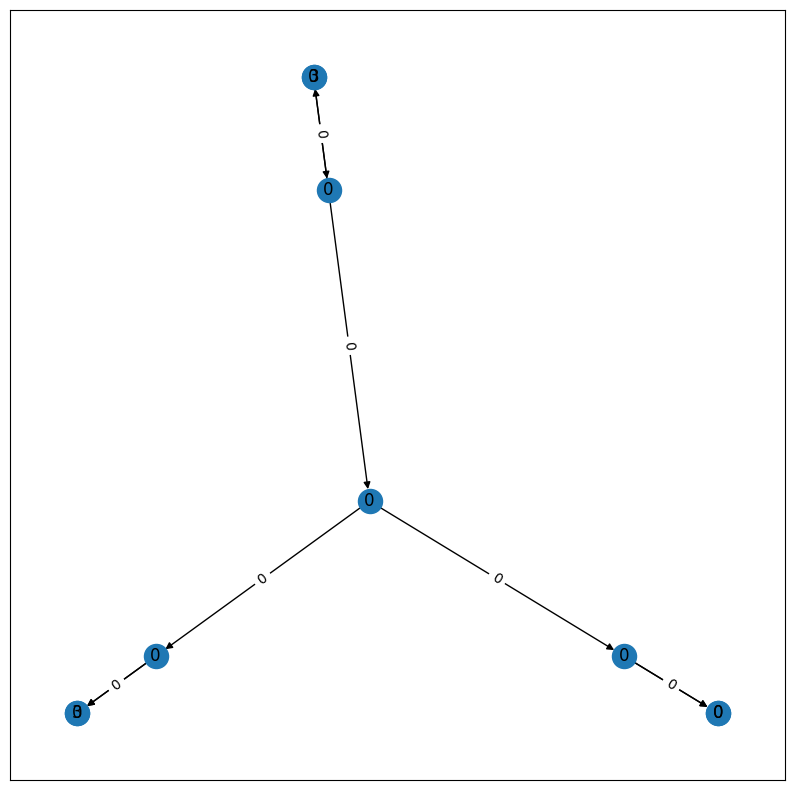


-----------------

t # 23
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
v 7 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0

Support: 1214


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


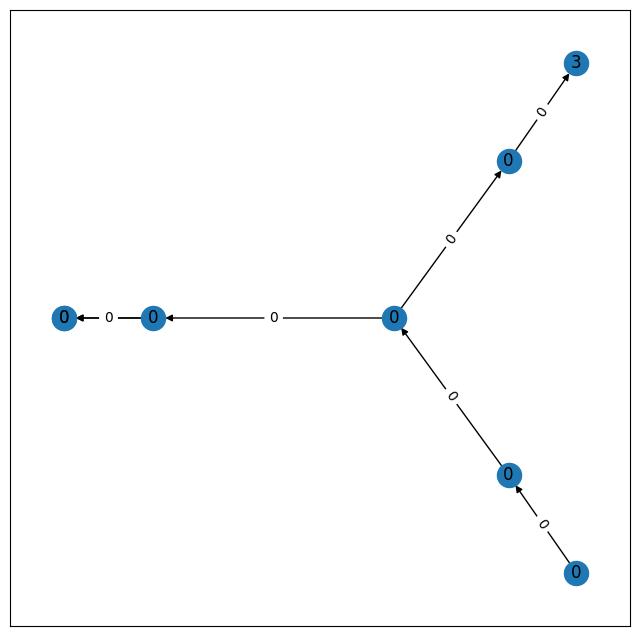


-----------------

t # 24
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
v 7 3
v 8 3
e 0 1 0
e 1 2 0
e 1 8 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0
e 6 7 0

Support: 1213


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


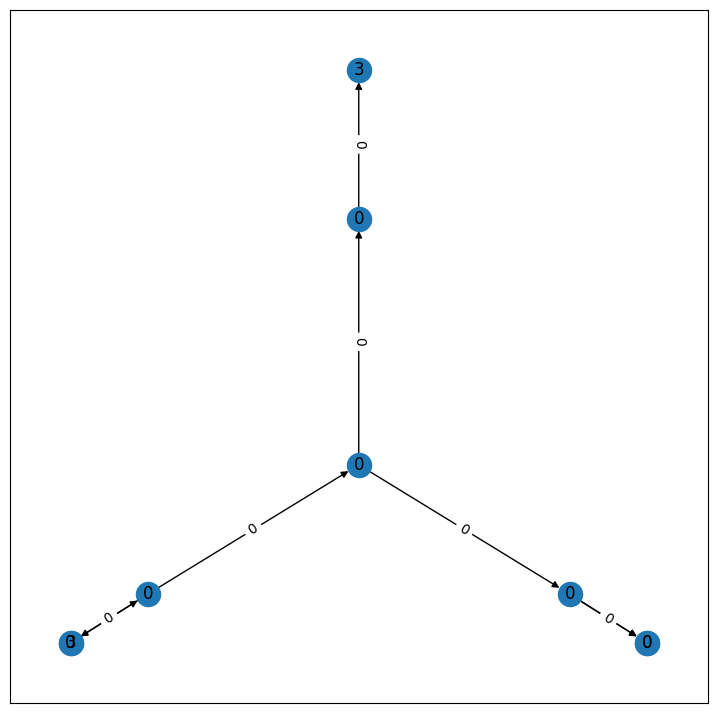


-----------------

t # 25
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 0
v 7 3
e 0 1 0
e 1 2 0
e 1 7 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0

Support: 1214


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


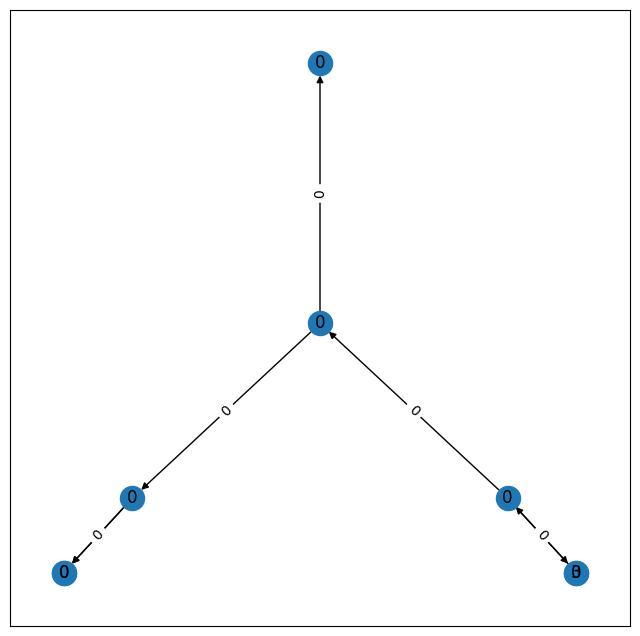


-----------------

t # 26
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
v 6 3
e 0 1 0
e 1 2 0
e 1 6 0
e 2 3 0
e 3 4 0
e 3 5 0

Support: 1249


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


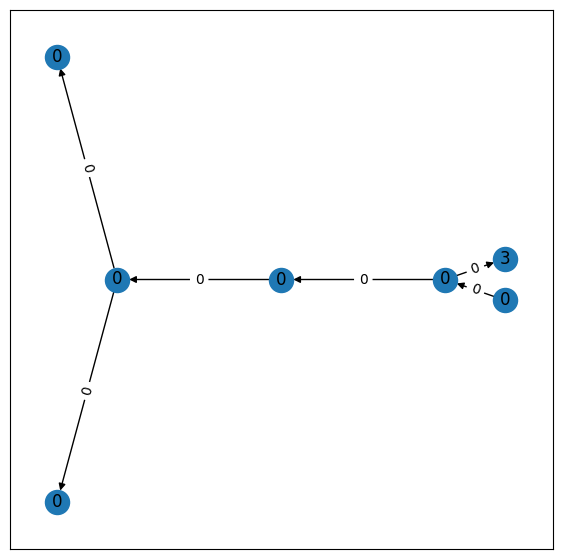


-----------------

t # 27
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 4
e 0 1 0
e 1 2 0
e 2 3 0
e 3 4 0
e 3 5 0

Support: 1372


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


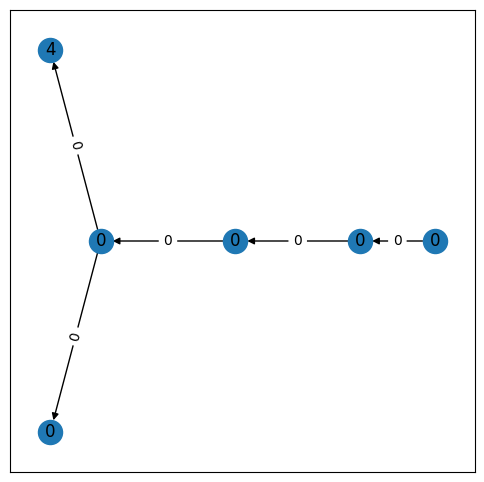


-----------------

t # 28
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 4
v 6 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 6 0
e 3 4 0
e 3 5 0

Support: 1277


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


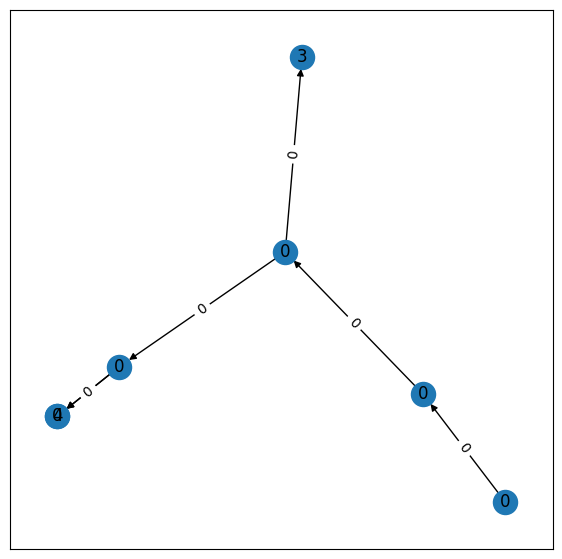


-----------------

t # 29
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 5 0
e 3 4 0

Support: 1398


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


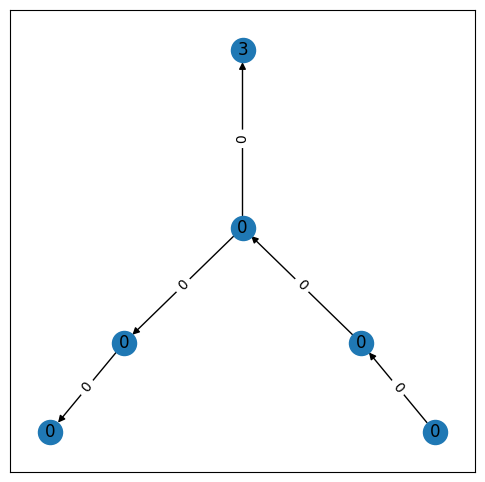


-----------------

t # 30
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
e 0 1 0
e 1 2 0
e 2 3 0
e 3 4 0

Support: 2501


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


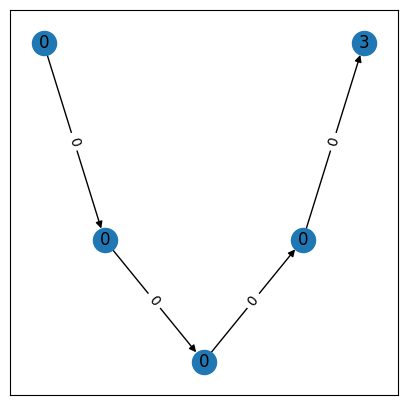


-----------------



/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


t # 31
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 3
e 0 1 0
e 1 2 0
e 1 5 0
e 2 3 0
e 3 4 0

Support: 1756


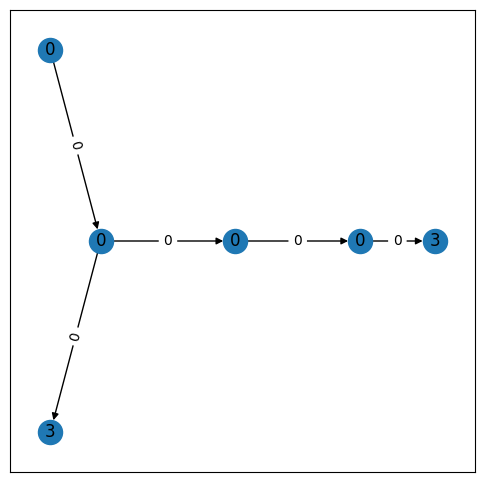


-----------------

t # 32
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 5 0
e 3 4 0

Support: 1393


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


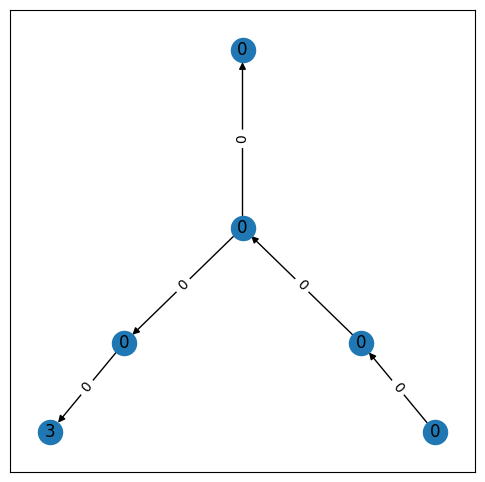


-----------------

t # 33
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 0
v 6 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 5 0
e 3 4 0
e 5 6 0

Support: 1375


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


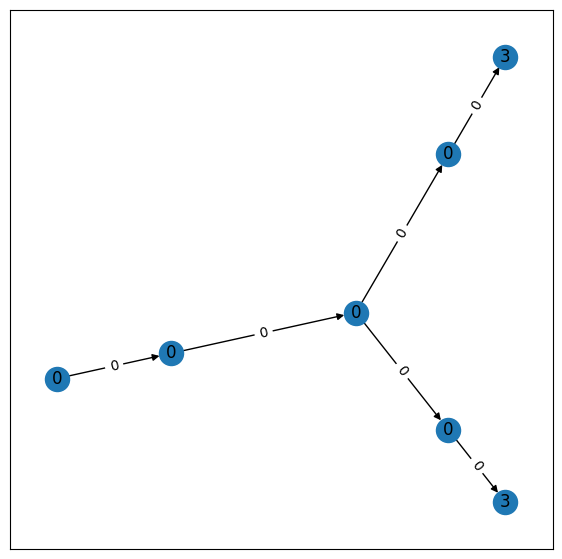


-----------------

t # 34
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 0
v 6 3
v 7 0
e 0 1 0
e 1 2 0
e 1 7 0
e 2 3 0
e 2 5 0
e 3 4 0
e 5 6 0

Support: 1215


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


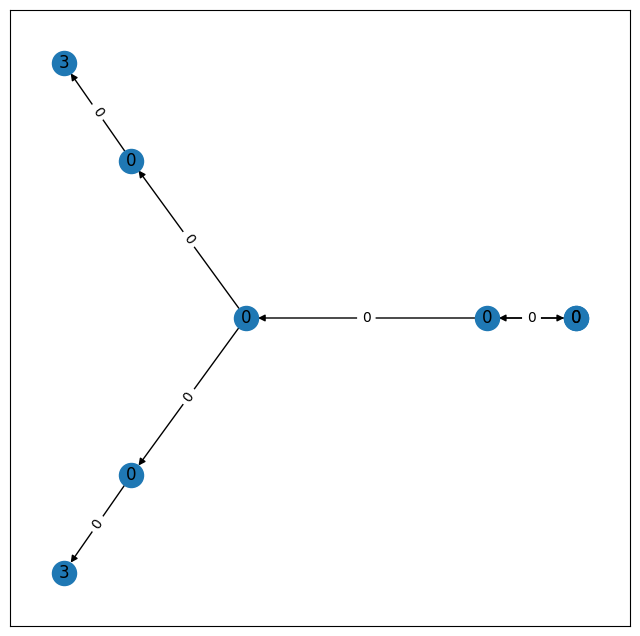


-----------------

t # 35
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 0
v 6 0
e 0 1 0
e 1 2 0
e 1 6 0
e 2 3 0
e 2 5 0
e 3 4 0

Support: 1216


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


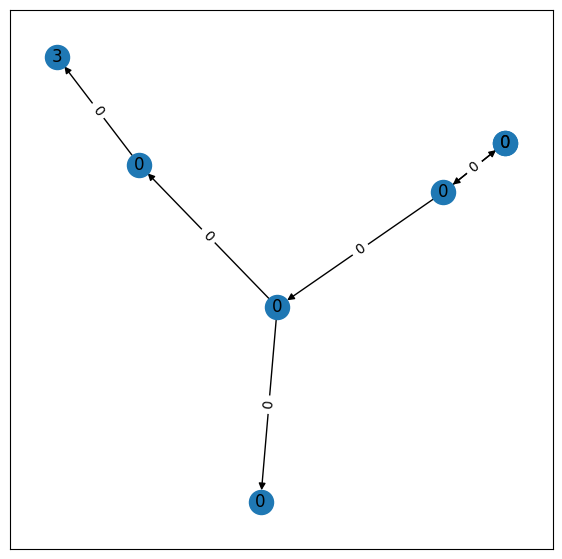


-----------------

t # 36
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 0
v 6 3
e 0 1 0
e 1 2 0
e 1 6 0
e 2 3 0
e 2 5 0
e 3 4 0

Support: 1375


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


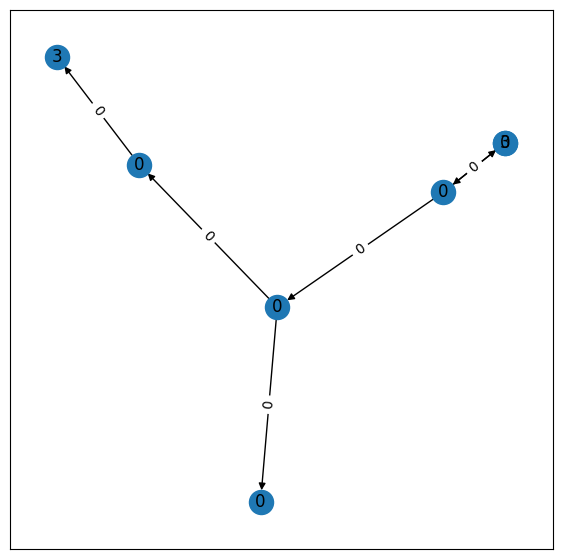


-----------------

t # 37
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
v 5 0
e 0 1 0
e 1 2 0
e 1 5 0
e 2 3 0
e 3 4 0

Support: 1252


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


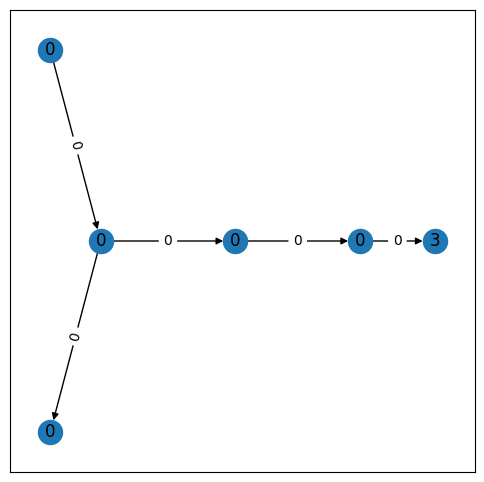


-----------------

t # 38
v 0 0
v 1 0
v 2 0
v 3 0
v 4 4
e 0 1 0
e 1 2 0
e 2 3 0
e 2 4 0

Support: 1765


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


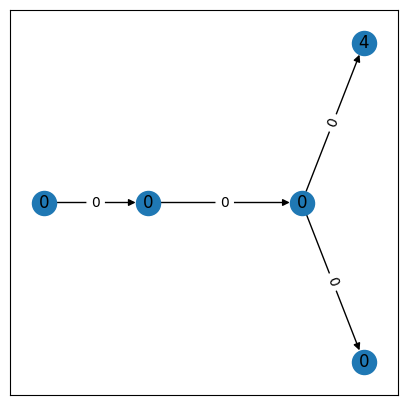


-----------------

t # 39
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
e 0 1 0
e 1 2 0
e 2 3 0
e 2 4 0

Support: 1840


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


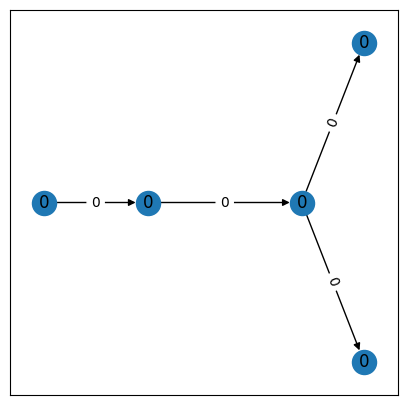


-----------------

t # 40
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 0
e 0 1 0
e 1 2 0
e 1 5 0
e 2 3 0
e 2 4 0

Support: 1216


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


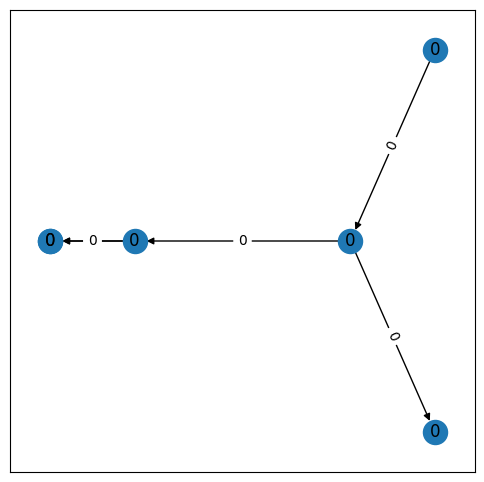


-----------------

t # 41
v 0 0
v 1 0
v 2 0
v 3 0
v 4 0
v 5 3
e 0 1 0
e 1 2 0
e 1 5 0
e 2 3 0
e 2 4 0

Support: 1831


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


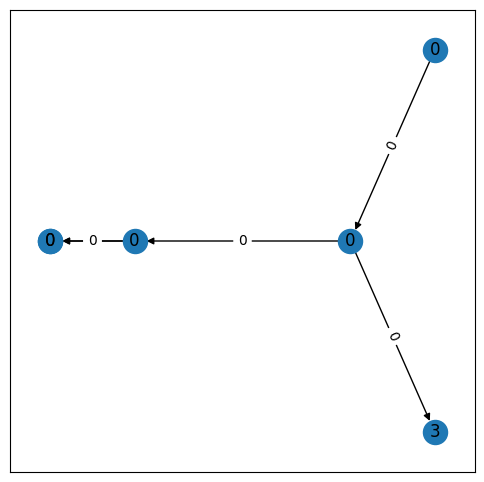


-----------------

t # 42
v 0 0
v 1 0
v 2 0
v 3 0
v 4 4
e 0 1 0
e 1 2 0
e 2 3 0
e 3 4 0

Support: 1502


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


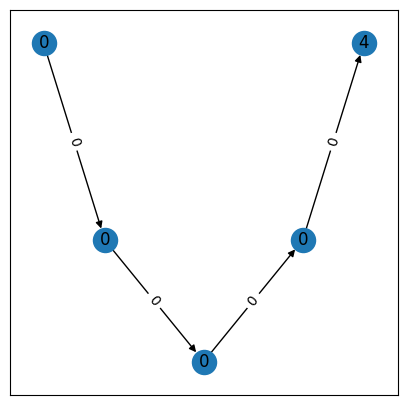


-----------------

t # 43
v 0 0
v 1 0
v 2 0
v 3 0
v 4 4
v 5 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 5 0
e 3 4 0

Support: 1388


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


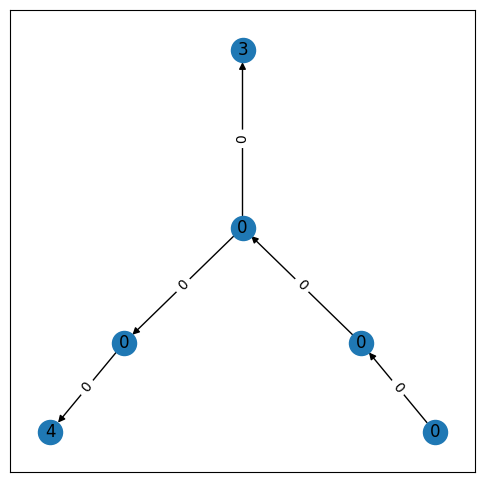


-----------------

t # 44
v 0 0
v 1 0
v 2 0
v 3 3
e 0 1 0
e 1 2 0
e 2 3 0

Support: 3409


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


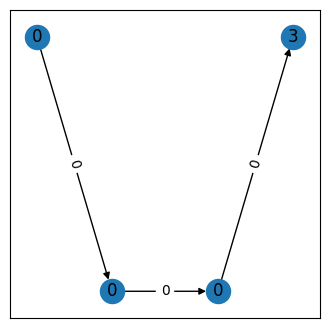


-----------------

t # 45
v 0 0
v 1 0
v 2 0
v 3 3
v 4 4
e 0 1 0
e 1 2 0
e 1 4 0
e 2 3 0

Support: 1681


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


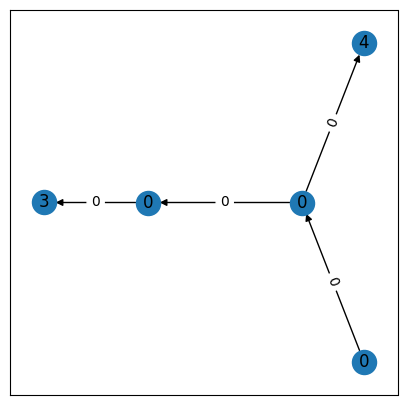


-----------------

t # 46
v 0 0
v 1 0
v 2 0
v 3 3
v 4 3
e 0 1 0
e 0 4 0
e 1 2 0
e 2 3 0

Support: 1759


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


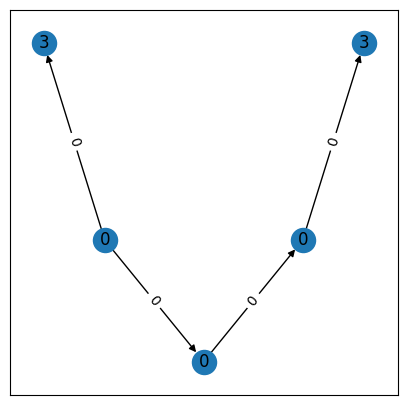


-----------------

t # 47
v 0 0
v 1 0
v 2 0
v 3 3
v 4 0
e 0 1 0
e 1 2 0
e 1 4 0
e 2 3 0

Support: 1855


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


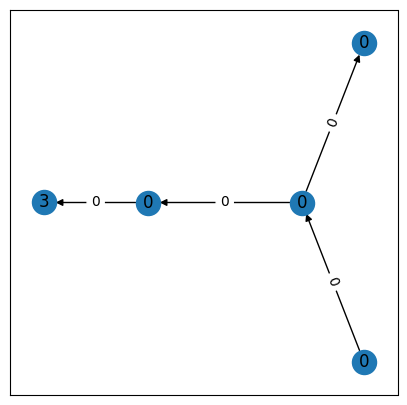


-----------------

t # 48
v 0 0
v 1 0
v 2 0
v 3 3
v 4 0
v 5 3
e 0 1 0
e 1 2 0
e 1 4 0
e 2 3 0
e 4 5 0

Support: 1377


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


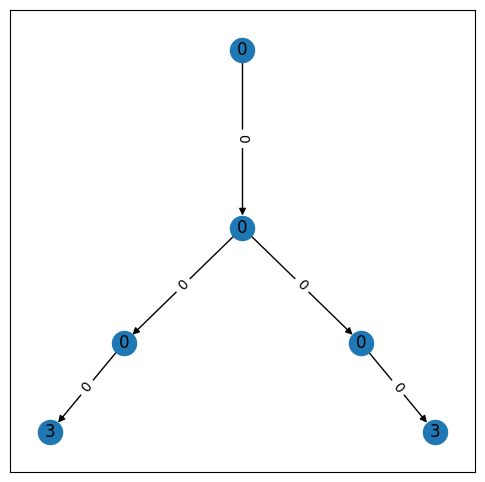


-----------------

t # 49
v 0 0
v 1 0
v 2 0
v 3 4
e 0 1 0
e 1 2 0
e 1 3 0

Support: 1776


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


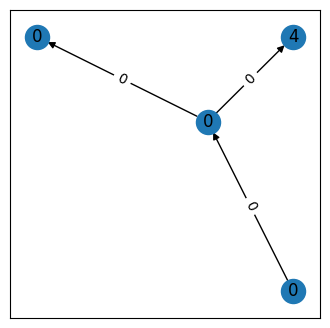


-----------------

t # 50
v 0 0
v 1 0
v 2 0
v 3 4
e 0 1 0
e 1 2 0
e 2 3 0

Support: 2060


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


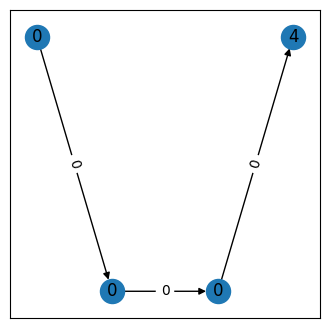


-----------------

t # 51
v 0 0
v 1 0
v 2 0
v 3 4
v 4 3
e 0 1 0
e 1 2 0
e 1 4 0
e 2 3 0

Support: 1927


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


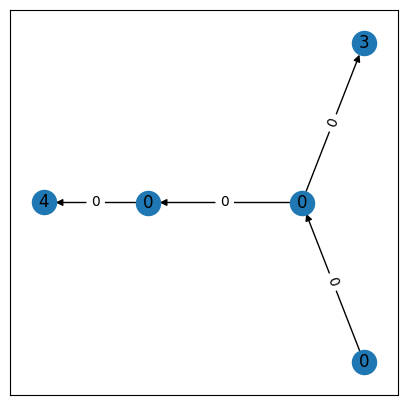


-----------------

t # 52
v 0 0
v 1 0
v 2 0
v 3 0
e 0 1 0
e 1 2 0
e 1 3 0

Support: 1855


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


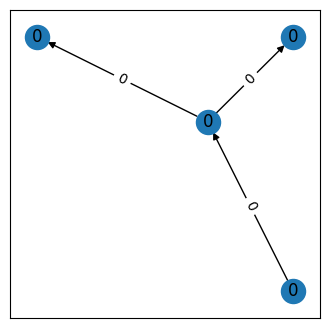


-----------------

t # 53
v 0 0
v 1 0
v 2 3
e 0 1 0
e 1 2 0

Support: 3414


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


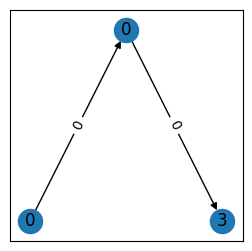


-----------------

t # 54
v 0 0
v 1 0
v 2 3
v 3 4
e 0 1 0
e 0 3 0
e 1 2 0

Support: 1937


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


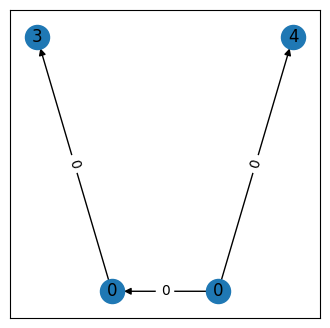


-----------------

t # 55
v 0 0
v 1 0
v 2 4
e 0 1 0
e 1 2 0

Support: 2065


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


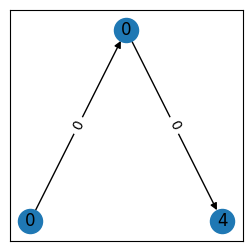


-----------------

t # 56
v 0 0
v 1 3
e 0 1 0

Support: 3423


/home/elouan/epita/lre/gnn_explainability/src/gspan_mine/gspan_mining/gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(


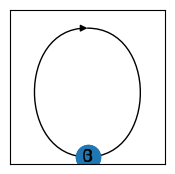


-----------------

Read:	0.19 s
Mine:	12.97 s
Total:	13.16 s


In [10]:
FLAGS, _ = parser.parse_known_args(args=args_str.split())
gs = main(FLAGS)
